In [1]:
!pip install torch
!pip install nilearn
!pip install nibabel
!pip install pandas
!pip install sklearn
!pip install matplotlib
!pip install numpy
!pip install torch torchvision

!git clone https://gitlab.inria.fr/epione_ML/mcvae.git


fatal: destination path 'mcvae' already exists and is not an empty directory.


In [2]:
%cd mcvae 
!python ./setup.py install


/content/mcvae
running install
running bdist_egg
running egg_info
writing src/mcvae.egg-info/PKG-INFO
writing dependency_links to src/mcvae.egg-info/dependency_links.txt
writing top-level names to src/mcvae.egg-info/top_level.txt
writing manifest file 'src/mcvae.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
copying build/lib/__init__.py -> build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mcvae
copying build/lib/mcvae/preprocessing.py -> build/bdist.linux-x86_64/egg/mcvae
copying build/lib/mcvae/__init__.py -> build/bdist.linux-x86_64/egg/mcvae
copying build/lib/mcvae/plot.py -> build/bdist.linux-x86_64/egg/mcvae
copying build/lib/mcvae/utilities.py -> build/bdist.linux-x86_64/egg/mcvae
copying build/lib/mcvae/diagnostics.py -> build/bdist.linux-x86_64/egg/mcvae
copying build/lib/mcvae/pytorch_modules.py -> build/bdist.linux-x86_64/egg/mcvae
byte-compiling build/b

In [0]:
#Before running this step, got to Runtime and select "Restart and run all..."
# When running this step may take a while...

import mcvae

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_decomposition import PLSCanonical, CCA

# Random data generation

Our journey across multivariate model starts with the generation of synthetic data. We first need to generate multivarite correlated random variables X and Y. To do so, we rely on the generative model we have seen during lesson:

$$ z\sim\mathcal{N}(0,1),$$
$$ X = z w_x,$$
$$ Y = z w_y.$$


In [198]:
# #############################################################################

# N subjects
n = 500
# here we define 2 Gaussian latents variables z = (l_1, l_2)
l1 = np.random.normal(size=n)
l2 = np.random.normal(size=n)

latents = np.array([l1, l2]).T

# We define two random transformations from the latent space to the space of X and Y respectively
transform_x = np.random.randint(-8,8, size = 10).reshape([2,5])
transform_y = np.random.randint(-8,8, size = 10).reshape([2,5])

# We compute data X = z w_x, and Y = z w_y
X = latents.dot(transform_x) 
Y = latents.dot(transform_y) 

# We we add some random Gaussian noise
X = X + 2*np.random.normal(size = n*5).reshape((n, 5))
Y = Y + 2*np.random.normal(size = n*5).reshape((n, 5))


print('The latent space has dimension ' + str(latents.shape))
print('The transformation for X has dimension ' + str(transform_x.shape))
print('The transformation for Y has dimension ' + str(transform_y.shape))

print('X has dimension ' + str(X.shape))
print('Y has dimension ' + str(Y.shape))


The latent space has dimension (500, 2)
The transformation for X has dimension (2, 5)
The transformation for Y has dimension (2, 5)
X has dimension (500, 5)
Y has dimension (500, 5)


[]

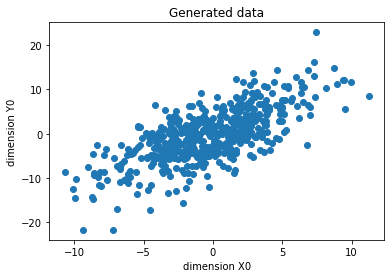

In [199]:
dimension_to_plot = 0

plt.scatter(X[:,dimension_to_plot], Y[:,dimension_to_plot])
plt.xlabel('dimension X' + str(dimension_to_plot))
plt.ylabel('dimension Y' + str(dimension_to_plot))
plt.title('Generated data')
plt.plot()

## PLS and scikit-learn: basic use


Our newly generated data can be already used to test the PLS and CCA provided by standard machie learning packages, such as scikit-learn.

In [0]:
##########################################################
# We first split the data in trainig and validation sets

# The training set is composed by a random sample of dimension N/2 
train_idx = np.random.choice(range(X.shape[0]), size = int(X.shape[0]/2), replace = False)
X_train = X[train_idx, :]

# The testing set is composed by the remaining subjects
test_idx = np.where(np.in1d(range(X.shape[0]), train_idx, assume_unique=True, invert = True))[0]
X_test = X[test_idx, :]

# We reuse the same indices to split the data Y
Y_train = Y[train_idx, :]
Y_test = Y[test_idx, :]


In [0]:
#######################################
# We fit PLS as provided by scikit-learn

#Defining PLS object
plsca = PLSCanonical(n_components=2)

#Fitting on train data
plsca.fit(X_train, Y_train)

#We project the training data in the latent dimension
X_train_r, Y_train_r = plsca.transform(X_train, Y_train)
#We project the testing data in the latent dimension
X_test_r, Y_test_r = plsca.transform(X_test, Y_test)

We note that the projections in the latent space retrieved by PLS are indeed correlated. The different dimensions of the projections are however uncorrelated. 

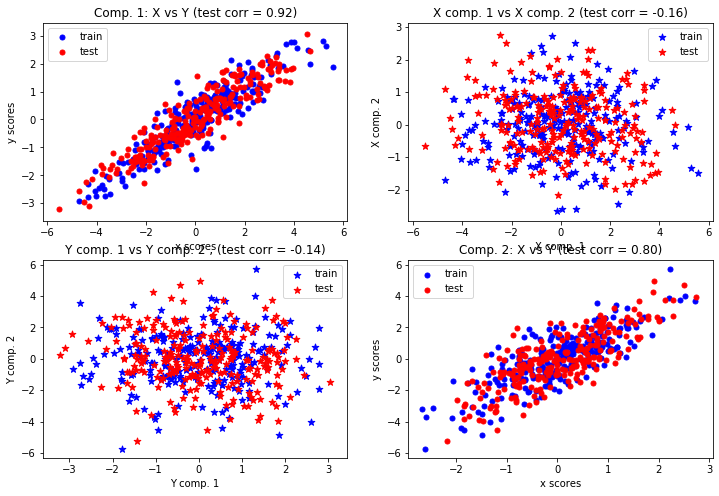

In [202]:
# Scatter plot of scores
# ~~~~~~~~~~~~~~~~~~~~~~
# 1) On diagonal plot X vs Y scores on each components
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.scatter(X_train_r[:, 0], Y_train_r[:, 0], label="train",
            marker="o", c="b", s=25)
plt.scatter(X_test_r[:, 0], Y_test_r[:, 0], label="test",
            marker="o", c="r", s=25)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title('Comp. 1: X vs Y (test corr = %.2f)' %
          np.corrcoef(X_test_r[:, 0], Y_test_r[:, 0])[0, 1])

plt.legend(loc="best")

plt.subplot(224)
plt.scatter(X_train_r[:, 1], Y_train_r[:, 1], label="train",
            marker="o", c="b", s=25)
plt.scatter(X_test_r[:, 1], Y_test_r[:, 1], label="test",
            marker="o", c="r", s=25)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title('Comp. 2: X vs Y (test corr = %.2f)' %
          np.corrcoef(X_test_r[:, 1], Y_test_r[:, 1])[0, 1])

plt.legend(loc="best")

# 2) Off diagonal plot components 1 vs 2 for X and Y
plt.subplot(222)
plt.scatter(X_train_r[:, 0], X_train_r[:, 1], label="train",
            marker="*", c="b", s=50)
plt.scatter(X_test_r[:, 0], X_test_r[:, 1], label="test",
            marker="*", c="r", s=50)
plt.xlabel("X comp. 1")
plt.ylabel("X comp. 2")
plt.title('X comp. 1 vs X comp. 2 (test corr = %.2f)'
          % np.corrcoef(X_test_r[:, 0], X_test_r[:, 1])[0, 1])
plt.legend(loc="best")



plt.subplot(223)
plt.scatter(Y_train_r[:, 0], Y_train_r[:, 1], label="train",
            marker="*", c="b", s=50)
plt.scatter(Y_test_r[:, 0], Y_test_r[:, 1], label="test",
            marker="*", c="r", s=50)
plt.xlabel("Y comp. 1")
plt.ylabel("Y comp. 2")
plt.title('Y comp. 1 vs Y comp. 2 , (test corr = %.2f)'
          % np.corrcoef(Y_test_r[:, 0], Y_test_r[:, 1])[0, 1])
plt.legend(loc="best")

plt.show()


In [203]:
#We can check the estimated projections
print('X projections: \n' + str(plsca.x_weights_))

print('Y projections: \n' + str(plsca.y_weights_))

X projections: 
[[-0.02793849  0.96662221]
 [-0.51191703 -0.06034058]
 [ 0.53424209  0.17403168]
 [ 0.50840244 -0.04057264]
 [-0.43962796  0.17339941]]
Y projections: 
[[ 0.05787282  0.51464122]
 [-0.39787169 -0.38223261]
 [-0.43294338 -0.3755656 ]
 [ 0.80106719 -0.36264317]
 [-0.09591791  0.56256827]]


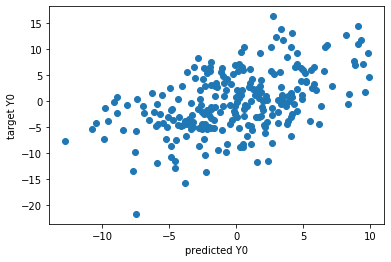

In [204]:
# We can also predict Y from X

predicted_Y_test = plsca.predict(X_test)

plt.scatter(predicted_Y_test[:,dimension_to_plot], Y_test[:,dimension_to_plot])
plt.ylabel('target Y' + str(dimension_to_plot))
plt.xlabel('predicted Y' + str(dimension_to_plot))

plt.show()


# Cross-validating components

In addition to sparsity, the optimal number of components in latent variable models can be identified by cross-validation. 
A common strategy is to train the model on a subset of the data and to quantify the *predicted residual error sum of squares* (PRESS) in non-overlapping testing data. We can finally choose the number of latent dimensions leading to the lowest average PRESS. 

In [0]:
n_cross_valid_run = 200

# number of components to test
n_components = 5

rep_results = [] 
for i in range(n_components):
  rep_results.append([])

for k in range(n_components):
  for i in range(n_cross_valid_run):

    # Sampling disjoint set of indices for splitting the data
    batch1_idx = np.random.choice(range(X_train.shape[0]), size = int(X_train.shape[0]/2), replace = False)
    batch2_idx = np.where(np.in1d(range(X_train.shape[0]), batch1_idx, assume_unique=True, invert = True))[0]

    # Creating independent data batches for X
    X_1 = X_train[batch1_idx, :]
    X_2 = X_train[batch2_idx, :]

    # Creating independent data batches for Y
    Y_1 = Y_train[batch1_idx, :]
    Y_2 = Y_train[batch2_idx, :]

    # Creating a model for each data batch
    plsca1 = PLSCanonical(n_components = k+1, scale = False)
    plsca2 = PLSCanonical(n_components = k+1, scale = False)

    # Fitting a model for each data batch
    plsca1.fit(X_1,Y_1)
    plsca2.fit(X_2,Y_2)

    # Quantifying the prediction error on the unseen data batch
    err1 = np.sum((plsca1.predict(X_2) - Y_2)**2)
    err2 = np.sum((plsca2.predict(X_1) - Y_1)**2)

    rep_results[k].append(np.mean([err1,err2]))


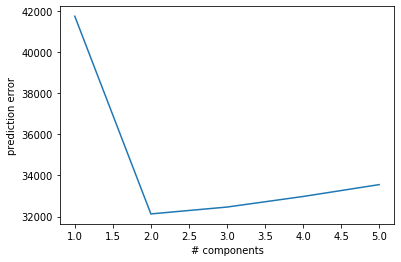

In [293]:
plt.plot(range(1,n_components+1),np.mean(rep_results, 1))
plt.xlabel('# components')
plt.ylabel('prediction error')
plt.show()

## Application on ADNI data

We are going to load volumetric and cognitive data for a sample from the ADNI dataset.
The exercise consists in applying the methods seen so far to understand the relationship between this kind of variables.

In [295]:
import pandas as pd

volumes = pd.read_csv('https://marcolorenzi.github.io/material/winter_school/volumes.csv')
volumes


,Unnamed: 0,RID,WholeBrain.bl,Ventricles.bl,Hippocampus.bl,MidTemp.bl,Entorhinal.bl
0,2,3,0.588244,0.044046,0.002769,0.009591,0.000932
1,3,4,0.687715,0.023582,0.004090,0.011679,0.002372
2,4,5,0.680556,0.020760,0.004312,0.013173,0.002702
3,7,8,0.679540,0.013436,0.004355,0.014380,0.003001
4,8,10,0.702524,0.018230,0.003728,0.013418,0.001819
...,...,...,...,...,...,...,...
912,1369,5288,0.702970,0.033736,0.004938,0.014715,0.002431
913,1370,5289,0.684950,0.023104,0.005107,0.016010,0.002401
914,1371,5290,0.736837,0.007401,0.005387,0.013707,0.002839
915,1372,5292,0.770626,0.011632,0.005554,0.013896,0.002963


In [0]:
volumes_value = np.array(volumes.iloc[:,2:]).reshape([len(volumes.RID),5])

# Standardization of volumetric measures
for i in range(volumes_value.shape[1]):
    volumes_value[:,i] = (volumes_value[:,i] - np.mean(volumes_value[:,i]))/np.std(volumes_value[:,i])

In [297]:
cognition = pd.read_csv('https://marcolorenzi.github.io/material/winter_school/cognition.csv')

cognition

,Unnamed: 0,RID,CDRSB.bl,ADAS11.bl,MMSE.bl,RAVLT.immediate.bl,RAVLT.learning.bl,RAVLT.forgetting.bl,FAQ.bl
0,2,3,4.5,22.00,20,22,1,4,10
1,3,4,1.0,14.33,27,37,7,4,0
2,4,5,0.0,8.67,29,37,4,4,0
3,7,8,0.0,5.00,28,51,7,3,0
4,8,10,5.0,12.33,24,20,2,5,11
...,...,...,...,...,...,...,...,...,...
912,1369,5288,0.0,6.00,30,53,6,3,0
913,1370,5289,0.0,9.00,29,50,10,7,0
914,1371,5290,0.0,5.00,29,53,8,4,1
915,1372,5292,0.0,3.00,30,41,9,7,1


In [0]:
cognition_value = np.array(cognition.iloc[:,2:]).reshape([len(cognition.RID),7])

# Standardization of cognitive measures

for i in range(cognition_value.shape[1]):
    cognition_value[:,i] = (cognition_value[:,i] - np.mean(cognition_value[:,i]))/np.std(cognition_value[:,i])

In [299]:
plsca_adni = PLSCanonical(n_components=3, scale = False)
plsca_adni.fit(cognition_value,volumes_value)
print(plsca_adni.x_weights_)
print(plsca_adni.y_weights_)

[[ 0.39899923  0.10784175  0.46702126]
 [ 0.46449063 -0.17600757  0.30801738]
 [-0.41970768  0.02252307  0.05284719]
 [-0.41480449  0.25193258  0.5752117 ]
 [-0.33759258 -0.35942915  0.527915  ]
 [ 0.09007329  0.86611085  0.09016765]
 [ 0.39338126 -0.11864597  0.25793539]]
[[-0.39539685  0.40966994  0.55358155]
 [ 0.30948675 -0.25355692  0.03687062]
 [-0.50592711 -0.48090226  0.50498596]
 [-0.48167611  0.53524535 -0.4254469 ]
 [-0.50980895 -0.50012484 -0.50613451]]


In [0]:
n_cross_valid_run = 50

# number of components to test
n_components = 5

rep_results = [] 
for i in range(n_components):
  rep_results.append([])

for k in range(n_components):
  for i in range(n_cross_valid_run):

    # Sampling disjoint set of indices for splitting the data
    batch1_idx = np.random.choice(range(cognition_value.shape[0]), size = int(cognition_value.shape[0]/2), replace = False)
    batch2_idx = np.where(np.in1d(range(cognition_value.shape[0]), batch1_idx, assume_unique=True, invert = True))[0]

    # Creating independent data batches for X
    X_1 = cognition_value[batch1_idx, :]
    X_2 = cognition_value[batch2_idx, :]

    # Creating independent data batches for Y
    Y_1 = volumes_value[batch1_idx, :]
    Y_2 = volumes_value[batch2_idx, :]

    # Creating a model for each data batch
    cca_adni1 = CCA(n_components = k+1, scale = False)
    cca_adni2 = CCA(n_components = k+1, scale = False)

    # Fitting a model for each data batch
    cca_adni1.fit(X_1,Y_1)
    cca_adni2.fit(X_2,Y_2)

    # Quantifying the prediction error on the unseen data batch
    err1 = np.sum((cca_adni1.predict(X_2) - Y_2)**2)
    err2 = np.sum((cca_adni2.predict(X_1) - Y_1)**2)

    rep_results[k].append(np.mean([err1,err2]))


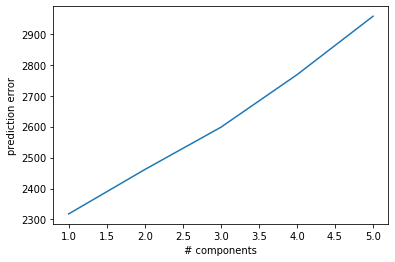

In [301]:
plt.plot(range(1,n_components+1),np.mean(rep_results, 1))
plt.xlabel('# components')
plt.ylabel('prediction error')
plt.show()

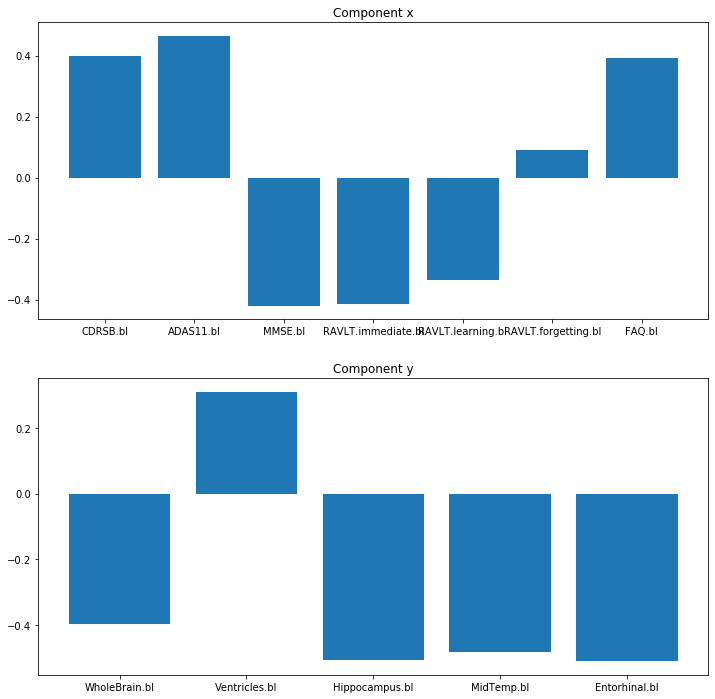

In [302]:
plsca_adni = PLSCanonical(n_components=1, scale = False)
plsca_adni.fit(cognition_value,volumes_value)


plt.figure(figsize=(12, 12))
plt.subplot(2,1,1)
plt.bar(np.arange(len(plsca_adni.x_weights_[:,0])), plsca_adni.x_weights_[:,0], tick_label = cognition.columns[2:])
plt.title('Component x')
plt.subplot(2,1,2)
plt.bar(np.arange(len(plsca_adni.y_weights_[:,0])), plsca_adni.y_weights_[:,0], tick_label = volumes.columns[2:])
plt.title('Component y')
plt.show()


# Into the guts of latent variable models

After playing with the builti-in implementation of PLS in scikit-learn, we are going to implement our own version based on the NIPALS method we saw during lesson.

## NIPALS for PLS

In [0]:
# Nipals method for PLS

n_components = 3


# Defining empty arrays where to store results

# Reconstruction from latent space to data
loading_x = np.ndarray([X.shape[1],n_components])
loading_y = np.ndarray([Y.shape[1],n_components])

# Projections into the latent space
weight_x = np.ndarray([X.shape[1],n_components])
weight_y = np.ndarray([Y.shape[1],n_components])

# Latent variables
scores_x = np.ndarray([X.shape[0],n_components])
scores_y = np.ndarray([Y.shape[0],n_components])


# Initialization of data matrices
current_X = X
current_Y = Y

for i in range(n_components):
    # Initialization of current latent variables as a data column
    t_x = current_X[:,0]

    # NIPALS iterations
    for _ in range(100):
        # estimating Y weights given data Y and latent variables from X
        w_y = current_Y.transpose().dot(t_x)/(t_x.transpose().dot(t_x))
        # normalizing Y weights
        w_y = w_y/np.sqrt(np.sum(w_y**2))

        # estimating latent variables from Y given data Y and Y weights
        t_y = current_Y.dot(w_y)
        # estimating X weights given data X and latent variables from Y
        w_x = current_X.transpose().dot(t_y)/(t_y.transpose().dot(t_y))
        # normalizing X weights
        w_x = w_x/np.sqrt(np.sum(w_x**2))

        # estimating latent variables from X given data X and X weights
        t_x = current_X.dot(w_x)

    # Weights are such that X * weights = t
    weight_x[:,i] = w_x
    weight_y[:,i] = w_y
    
    # Latent variables
    scores_x[:,i] = t_x
    scores_x[:,i] = t_y
    
    # Loadings obtained by regressing X on t (X = t * loadings)
    
    loading_x[:,i] = np.dot(current_X.T, t_x)/t_x.transpose().dot(t_x) 
    loading_y[:,i] = np.dot(current_Y.T, t_y)/t_y.transpose().dot(t_y)
    
    # Deflation = current_data - current_reconstruction
    
    current_X = current_X - t_x.reshape(len(t_x),1).dot(w_x.reshape(1,len(w_x)))
    current_Y = current_Y - t_y.reshape(len(t_y),1).dot(w_y.reshape(1,len(w_y)))
    

In [304]:
print('The estimated projections functions of of X are: \n' + str(weight_x))

print('\n The estimated projections functions of of Y are: \n' + str(weight_y))

The estimated projections functions of of X are: 
[[ 0.03540211  0.87305088  0.10891483]
 [ 0.43084156 -0.08271325 -0.02224491]
 [-0.58724659  0.32485194 -0.46356353]
 [-0.6479673  -0.20324076  0.62214427]
 [ 0.22000469  0.29000878  0.62103792]]

 The estimated projections functions of of Y are: 
[[-0.02380991  0.41523459  0.23128022]
 [ 0.38334291 -0.41570465 -0.08092843]
 [ 0.45096845 -0.44630494 -0.38384722]
 [-0.79845829 -0.38979341 -0.37155341]
 [ 0.10757841  0.551038   -0.80905465]]


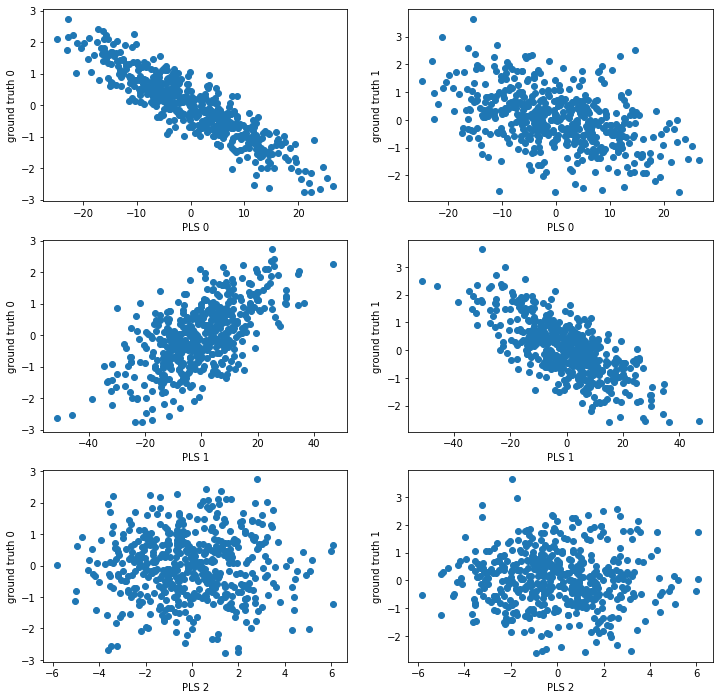

In [221]:
plt.figure(figsize=(12, 12))
plt.subplot(3,2,1)
plt.scatter(scores_x[:,0], latents[:,0])
plt.xlabel('PLS 0')
plt.ylabel('ground truth 0')
plt.subplot(3,2,2)
plt.scatter(scores_x[:,0], latents[:,1])
plt.xlabel('PLS 0')
plt.ylabel('ground truth 1')
plt.subplot(3,2,3)
plt.scatter(scores_x[:,1], latents[:,0])
plt.xlabel('PLS 1')
plt.ylabel('ground truth 0')
plt.subplot(3,2,4)
plt.scatter(scores_x[:,1], latents[:,1])
plt.xlabel('PLS 1')
plt.ylabel('ground truth 1')
plt.subplot(3,2,5)
plt.scatter(scores_x[:,2], latents[:,0])
plt.xlabel('PLS 2')
plt.ylabel('ground truth 0')
plt.subplot(3,2,6)
plt.scatter(scores_x[:,2], latents[:,1])
plt.xlabel('PLS 2')
plt.ylabel('ground truth 1')
plt.show()

Once that the PLS parameters are estimated, we can solve the regression problem for predicting Y from X. We adopt the scheme used in scikit-learn, where a rotation matrix is first estimated to accoung for non-cummutativity between projection (weights) and reconstruction (loadings).



In [0]:
# Identifying rotation from X to t
# t_x * loadings_x = X
# t_x * loadings_x.T * weight = X * weight 
# t_x =  X * weight * (loadings_x.T * weight)^-1 = X * rotations_x

rotations_x = weight_x.dot(np.linalg.pinv(loading_x.T.dot(weight_x)))

# Solving the regression from X to Y
# Y = t_x * loadings_y.T
# Y = X * rotations_x * loadings_y.T

regression_coef = np.dot(rotations_x, loading_y.T)

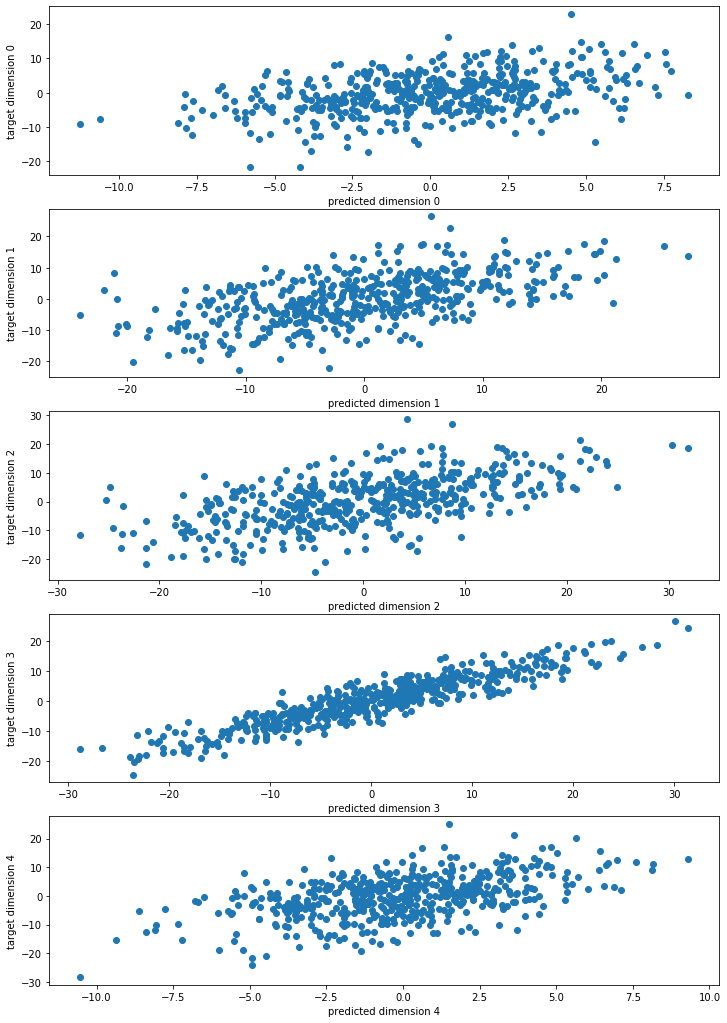

In [306]:
plt.figure(figsize=(12, 18))
for i in range(Y.shape[1]):
  plt.subplot(Y.shape[1], 1, i+1)
  plt.scatter(X.dot(regression_coef)[:,i], Y[:,i])
  plt.xlabel('predicted dimension ' + str(i))
  plt.ylabel('target dimension ' + str(i))
plt.show()

In [0]:
# Comparing with SVD of covariance matrix

eig_val_x, eig_vect, eig_val_y = np.linalg.svd(X.transpose().dot(Y))

In [310]:
print('Eigenvalues for X \n' + str(np.real(eig_val_x[:,:3])))
print('Estimated weights for X\n' + str(np.real(weight_x[:,:3])))

Eigenvalues for X 
[[ 0.03540211 -0.87305088  0.10891483]
 [ 0.43084156  0.08271325 -0.02224491]
 [-0.58724659 -0.32485194 -0.46356353]
 [-0.6479673   0.20324076  0.62214427]
 [ 0.22000469 -0.29000878  0.62103792]]
Estimated weights for X
[[ 0.03540211  0.87305088  0.10891483]
 [ 0.43084156 -0.08271325 -0.02224491]
 [-0.58724659  0.32485194 -0.46356353]
 [-0.6479673  -0.20324076  0.62214427]
 [ 0.22000469  0.29000878  0.62103792]]


In [311]:
print('Eigenvalues for Y \n' + str(np.real(eig_val_y.T[:,:3])))
print('Estimated weights for Y\n' + str(np.real(weight_y[:,:3])))

Eigenvalues for Y 
[[-0.02380991 -0.41523459  0.23128022]
 [ 0.38334291  0.41570465 -0.08092843]
 [ 0.45096845  0.44630494 -0.38384722]
 [-0.79845829  0.38979341 -0.37155341]
 [ 0.10757841 -0.551038   -0.80905465]]
Estimated weights for Y
[[-0.02380991  0.41523459  0.23128022]
 [ 0.38334291 -0.41570465 -0.08092843]
 [ 0.45096845 -0.44630494 -0.38384722]
 [-0.79845829 -0.38979341 -0.37155341]
 [ 0.10757841  0.551038   -0.80905465]]


In [312]:
# PLS in scikit-learn 

plsca = PLSCanonical(n_components=3, scale = False)
plsca.fit(X, Y)

PLSCanonical(algorithm='nipals', copy=True, max_iter=500, n_components=3,
             scale=False, tol=1e-06)

In [228]:
print(plsca.x_weights_)
print(plsca.y_weights_)

[[-0.03471972  0.8729035   0.09640466]
 [-0.43089291 -0.08096107 -0.03110319]
 [ 0.58749531  0.32351047 -0.46013024]
 [ 0.64779741 -0.20059969  0.61602427]
 [-0.21984909  0.29425419  0.6312947 ]]
[[ 0.02459937  0.4157018   0.21438821]
 [-0.38413401 -0.41489616 -0.08131466]
 [-0.45197309 -0.44528021 -0.39262434]
 [ 0.79761104 -0.3912785  -0.3761979 ]
 [-0.10664378  0.55107155 -0.80730842]]


## Reduced Rank Regression

We finally review reduced rank regression through the eigen-decomposition seen during lesson.

In [0]:
# Reduced Rank Regression

n_components = 2
Gamma = np.eye(n_components)

SYX = np.dot(Y.T,X)

SXX = np.dot(X.T,X)

U, S, V = np.linalg.svd(np.dot(SYX, np.dot(np.linalg.pinv(SXX), SYX.T)))

A = V[0:n_components, :].T

B = np.dot(np.dot(A.T,SYX), np.linalg.pinv(SXX))

In [332]:
A

array([[-0.38978968, -0.14384881],
       [ 0.53428962, -0.18536304],
       [ 0.58921389, -0.2353405 ],
       [ 0.03884006,  0.88788791],
       [-0.46251167, -0.31814773]])

In [333]:
B

array([[-2.52919354,  0.57209126, -1.3602572 ,  0.51460294, -0.94675451],
       [-0.58801873, -0.16618405,  0.06205908,  0.40976233, -0.39308178]])

In [0]:
regression_coef_rrr = np.dot(A,B)

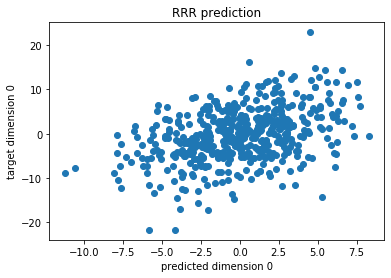

In [335]:
plt.scatter(np.dot(X,regression_coef)[:,0],Y[:,0])
plt.xlabel('predicted dimension 0')
plt.ylabel('target dimension 0')
plt.title('RRR prediction')
plt.show()

# Sparsity in latent variable models

We now focus on the effect of spurious variables in mutivariate models. To explore this new setting, we are going add spurious random features to our data matrices X and Y.  

In [0]:
## Adding 3 random dimensions
## No association is expected from these features

X_ext = np.hstack([X,np.random.randn(n*3).reshape([n,3])])
Y_ext = np.hstack([Y,np.random.randn(n*3).reshape([n,3])])

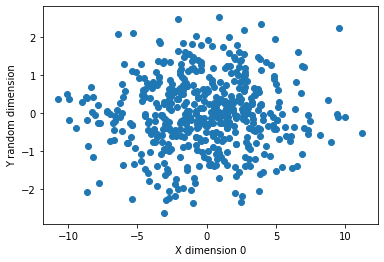

In [337]:
plt.scatter(X_ext[:,0], Y_ext[:,-1])
plt.xlabel('X dimension 0')
plt.ylabel('Y random dimension')
plt.show()

In [0]:
from sklearn import linear_model

n_components = 3

#### Sparse PLS via regularization in NIPALS [Waaijenborg, et al 2007]
# Everything is as for the standard NIPALS algorithm, with the added sparse estimation step   

loading_x_sparse = np.ndarray([X_ext.shape[1],n_components])
loading_y_sparse = np.ndarray([Y_ext.shape[1],n_components])

scores_x_sparse = np.ndarray([X_ext.shape[0],n_components])
scores_y_sparse = np.ndarray([Y_ext.shape[0],n_components])

weight_x_sparse = np.ndarray([X_ext.shape[1],n_components])
weight_y_sparse = np.ndarray([Y_ext.shape[1],n_components])

current_X = X_ext
current_Y = Y_ext

## Penalty parameter for regularization
penalty = 10

eps = 1e-4

for i in range(n_components):
    t_x = current_X[:,0]
    for _ in range(100):
        w_y = current_Y.transpose().dot(t_x)/(t_x.transpose().dot(t_x))
        w_y = w_y/np.sqrt(np.sum(w_y**2))
        t_y = current_Y.dot(w_y)
        w_x = current_X.transpose().dot(t_y)/(t_y.transpose().dot(t_y))
        w_x = w_x/np.sqrt(np.sum(w_x**2))
        t_x = current_X.dot(w_x)
        
        ## Estimating sparse model for the weights of X
        lasso_x = linear_model.Lasso(alpha = penalty)
        lasso_x.fit(t_x.reshape(-1, 1), current_X)
        
        ## Estimating sparse model for the weights of Y
        lasso_y = linear_model.Lasso(alpha = penalty)
        lasso_y.fit(t_y.reshape(-1, 1), current_Y)
        
        # Replacing the original weights with the sparse estimation
        w_x = (lasso_x.coef_ / (np.sqrt(np.sum(lasso_x.coef_**2) + eps))).reshape([X_ext.shape[1]]) 
        w_y = (lasso_y.coef_ / (np.sqrt(np.sum(lasso_y.coef_**2) + eps))).reshape([Y_ext.shape[1]])

    # Weights are such that X * weights = t
    weight_x_sparse[:,i] = w_x
    weight_y_sparse[:,i] = w_y
    
    # Latent dimensions
    scores_x_sparse[:,i] = t_x
    scores_x_sparse[:,i] = t_y
    
    # Loadings obtained by regressing X on t (X = t * loadings)
    
    loading_x_sparse[:,i] = np.dot(current_X.T, t_x)/t_x.transpose().dot(t_x) 
    loading_y_sparse[:,i] = np.dot(current_Y.T, t_y)/t_y.transpose().dot(t_y)
    
    # Deflation
    
    current_X = current_X - t_x.reshape(len(t_x),1).dot(w_x.reshape(1,len(w_x)))
    current_Y = current_Y - t_y.reshape(len(t_y),1).dot(w_y.reshape(1,len(w_y)))
    

We observe that the new weights are similar to the ones estimated before. However the parameters associated with the spurious dimension are entirely set to zero. This indicates that the model does not find these features necessary to explain the common variability between X and Y. There are also other weights which are set to zero, corresponding to the third latent dimension. This makes sense, as our synthetic data was indeed created with only two latent dimensions.

In [346]:
weight_x_sparse

array([[ 0.05249974,  0.99893154,  0.        ],
       [ 0.41637439, -0.        , -0.        ],
       [-0.57039142,  0.        , -0.        ],
       [-0.67308824, -0.        , -0.        ],
       [ 0.21299127,  0.        , -0.        ],
       [-0.        ,  0.        ,  0.        ],
       [-0.        , -0.        ,  0.        ],
       [-0.        , -0.        ,  0.        ]])

In [347]:
## PLS result from scikit-learn PLS on the data augmented with spurious dimensions 

plsca = PLSCanonical(n_components=3, scale = False)
plsca.fit(X_ext, Y_ext)
print(plsca.x_weights_)



[[-3.47162411e-02  8.72529782e-01  2.56288311e-02]
 [-4.30891331e-01 -8.08586253e-02 -1.78346492e-02]
 [ 5.87495006e-01  3.23338728e-01 -3.71933657e-01]
 [ 6.47788349e-01 -2.00534680e-01  5.59627649e-01]
 [-2.19849306e-01  2.94111563e-01  6.86314205e-01]
 [ 3.04247241e-03  1.56531452e-03 -1.28991679e-01]
 [-1.99911703e-03 -1.75753795e-02 -1.91249002e-01]
 [-5.87836881e-04 -2.40544253e-02 -1.52529064e-01]]


# Multi-channel Variational Autoencoder

The last part of this tutorial concerns the use of the *multi-channel variational autoencoder* (https://gitlab.inria.fr/epione_ML/mcvae), a more advanced  methods for the joint analysis and prediction of several modalities.




In [348]:
from mcvae import pytorch_modules, utilities, preprocessing, plot, diagnostics
from pathlib import Path
import torch

DEVICE = pytorch_modules.DEVICE
print(f"Running on {DEVICE}")

Running on cpu


In [0]:
### Data in mcvae is specified by: 
# 1 - a dictionary with the data characteristics

init_dict = {
    'n_channels': 2, # X and Y
    'lat_dim': n_components,  
    'n_feats': tuple([X.shape[1], Y.shape[1]]),
}

# 2 - a list with the different modalities

data = []
data.append(torch.FloatTensor(X)) #warning: data matrices must be converted to type torch.FLoatTensor
data.append(torch.FloatTensor(Y)) #warning: data matrices must be converted to type torch.FLoatTensor

In [0]:
# Here we create an instance of the model

adam_lr = 1e-2
n_epochs = 4000

# Multi-Channel VAE
torch.manual_seed(24)
model = pytorch_modules.MultiChannelBase(**init_dict)

In [351]:
###################
## Model Fitting ##
###################

model.init_loss()
model.optimizer = torch.optim.Adam(model.parameters(), lr=adam_lr)
model.optimize(epochs = n_epochs, data = data)

====> Epoch:    0/4000 (0%)	Loss: 47564.4492	LL: -852.4691	KL: 46711.9805	LL/KL: -0.0182
====> Epoch:  100/4000 (2%)	Loss: 96.6974	LL: -73.5860	KL: 23.1115	LL/KL: -3.1840
====> Epoch:  200/4000 (5%)	Loss: 88.6411	LL: -71.0570	KL: 17.5841	LL/KL: -4.0410
====> Epoch:  300/4000 (8%)	Loss: 83.5511	LL: -69.7444	KL: 13.8067	LL/KL: -5.0515
====> Epoch:  400/4000 (10%)	Loss: 79.7611	LL: -68.6403	KL: 11.1208	LL/KL: -6.1723
====> Epoch:  500/4000 (12%)	Loss: 77.1743	LL: -67.9897	KL: 9.1846	LL/KL: -7.4026
====> Epoch:  600/4000 (15%)	Loss: 75.3378	LL: -67.5515	KL: 7.7863	LL/KL: -8.6757
====> Epoch:  700/4000 (18%)	Loss: 73.9215	LL: -67.1420	KL: 6.7796	LL/KL: -9.9036
====> Epoch:  800/4000 (20%)	Loss: 72.6633	LL: -66.5818	KL: 6.0816	LL/KL: -10.9481
====> Epoch:  900/4000 (22%)	Loss: 71.8977	LL: -66.2891	KL: 5.6087	LL/KL: -11.8190
====> Epoch: 1000/4000 (25%)	Loss: 71.0123	LL: -65.8181	KL: 5.1943	LL/KL: -12.6713
====> Epoch: 1100/4000 (28%)	Loss: 70.2790	LL: -65.4644	KL: 4.8146	LL/KL: -13.5971
====

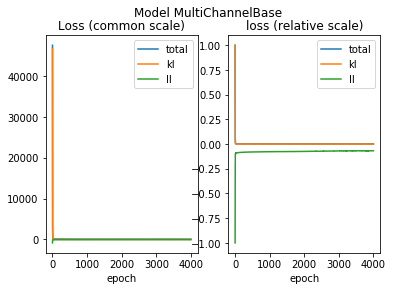

In [352]:
## Plotting model convergence

diagnostics.plot_loss(model)

The plot above indicates that the model converged smoothly.

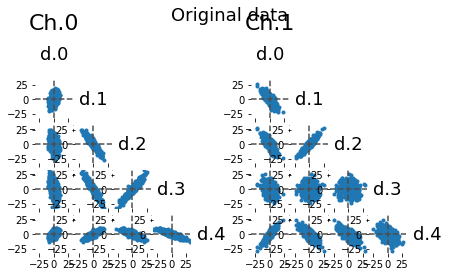

In [353]:
# We can plot the original data, dimension x dimension

plot.lsplom(data, title = 'Original data')

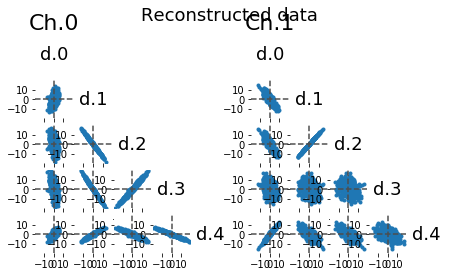

In [354]:
# We can estimate the reconstructed data (decoding from the latent space)
x_hat = model.reconstruct(data)

# Plotting the reconstructed data, dimension x dimension
plot.lsplom(utilities.ltonumpy(x_hat), title = 'Reconstructed data')

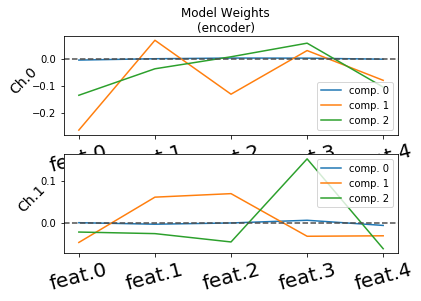

In [355]:
## Plotting the weights of the encoder

diagnostics.plot_weights(model, side = 'encoder')

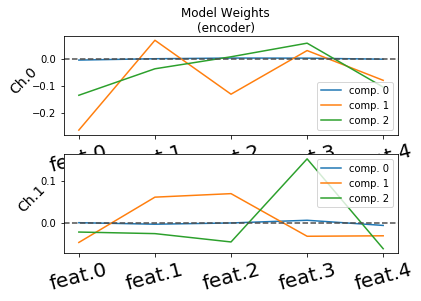

In [356]:
## Plotting the weights of the decoder

diagnostics.plot_weights(model, side = 'encoder')

In [0]:
# Inspecting model parameters

# Decoding parameters
weights_decoding_X = model.W_out[0]
weights_decoding_Y = model.W_out[1]

In [359]:
weights_decoding_X.weight

Parameter containing:
tensor([[-0.0386, -1.0771, -1.1511],
        [-0.0898,  1.3579, -2.6029],
        [ 0.2670, -2.1379,  3.2311],
        [ 0.2149, -1.6415,  4.0100],
        [-0.0494,  0.2611, -1.6838]], requires_grad=True)

In [252]:
weights_decoding_Y.weight

Parameter containing:
tensor([[ 0.0162, -2.3709, -0.9592],
        [-0.0530,  3.3597, -0.2333],
        [ 0.0964,  3.7164, -0.3355],
        [ 0.1048, -0.0786,  3.5085],
        [-0.0966, -2.7281, -1.6852]], requires_grad=True)

In [0]:
# Encoding parameters
weights_encoding_X = model.W_mu[0]
weights_encoding_Y = model.W_mu[1]

In [363]:
weights_encoding_X.weight

Parameter containing:
tensor([[-0.0041,  0.0009,  0.0033,  0.0030, -0.0008],
        [-0.2639,  0.0694, -0.1306,  0.0312, -0.0792],
        [-0.1346, -0.0364,  0.0081,  0.0586, -0.1044]], requires_grad=True)

In [364]:
weights_encoding_Y.weight

Parameter containing:
tensor([[ 0.0012, -0.0024,  0.0005,  0.0069, -0.0052],
        [-0.0451,  0.0610,  0.0692, -0.0306, -0.0295],
        [-0.0207, -0.0244, -0.0440,  0.1507, -0.0598]], requires_grad=True)

In [0]:
# Here we compute the encoding and plot the latent dimensions against our original ground truth for the syntetic data

encoding = model.encode(data)

encoding_x = encoding[0].loc.detach().numpy()
encoding_y = encoding[1].loc.detach().numpy()

We note that the estimated encoding is correlated with the original latent dimensions. There seems to be however some redundancy. This motivates the use of a *sparse model*.

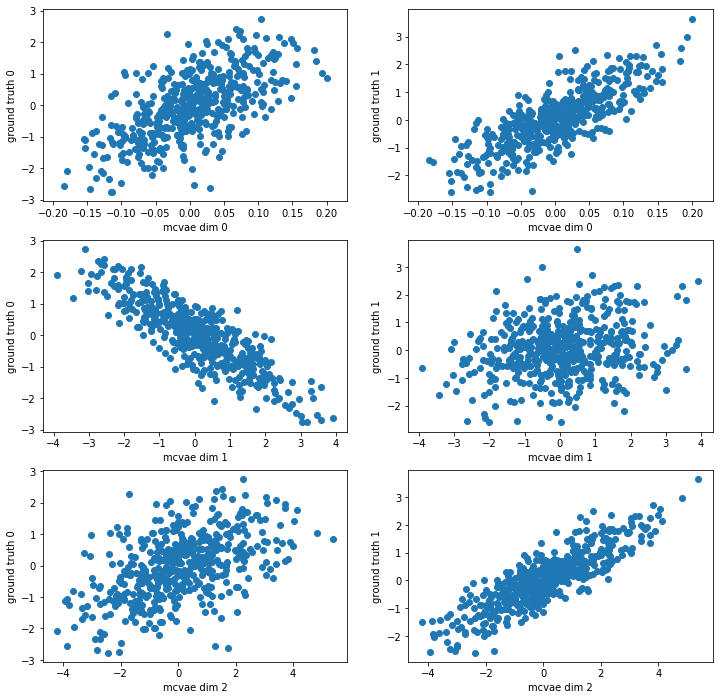

In [367]:
plt.figure(figsize=(12, 12))
for idx,k in enumerate(range(n_components)):
  plt.subplot(n_components,2,2*idx+1)
  plt.scatter(encoding_x[:,k], latents[:,0])
  plt.xlabel(str('mcvae dim ') + str(k))
  plt.ylabel('ground truth 0')
  plt.subplot(n_components,2,2*idx+2)
  plt.scatter(encoding_x[:,k], latents[:,1])
  plt.xlabel(str('mcvae dim ') + str(k))
  plt.ylabel('ground truth 1')
plt.show()

In [368]:
# Calling sparse mcvae

adam_lr = 1e-2
n_epochs = 4000

model_sparse1 = pytorch_modules.MultiChannelSparseVAE(**init_dict)

model_sparse1.init_loss()
model_sparse1.optimizer = torch.optim.Adam(model_sparse1.parameters(), lr=adam_lr)
model_sparse1.optimize(epochs = n_epochs, data = data)


====> Epoch:    0/4000 (0%)	Loss: 90.3208	LL: -87.7140	KL: 2.6068	LL/KL: -33.6477
====> Epoch:  100/4000 (2%)	Loss: 62.5599	LL: -59.1778	KL: 3.3820	LL/KL: -17.4977
====> Epoch:  200/4000 (5%)	Loss: 60.1446	LL: -55.0621	KL: 5.0825	LL/KL: -10.8337
====> Epoch:  300/4000 (8%)	Loss: 58.9525	LL: -52.2948	KL: 6.6577	LL/KL: -7.8548
====> Epoch:  400/4000 (10%)	Loss: 58.1834	LL: -50.3463	KL: 7.8371	LL/KL: -6.4241
====> Epoch:  500/4000 (12%)	Loss: 57.5582	LL: -49.0690	KL: 8.4892	LL/KL: -5.7802
====> Epoch:  600/4000 (15%)	Loss: 57.7183	LL: -48.9590	KL: 8.7593	LL/KL: -5.5893
====> Epoch:  700/4000 (18%)	Loss: 57.5415	LL: -48.7090	KL: 8.8326	LL/KL: -5.5147
====> Epoch:  800/4000 (20%)	Loss: 57.5386	LL: -48.6347	KL: 8.9039	LL/KL: -5.4622
====> Epoch:  900/4000 (22%)	Loss: 57.5061	LL: -48.5615	KL: 8.9446	LL/KL: -5.4291
====> Epoch: 1000/4000 (25%)	Loss: 57.4574	LL: -48.5308	KL: 8.9266	LL/KL: -5.4366
====> Epoch: 1100/4000 (28%)	Loss: 57.6604	LL: -48.7783	KL: 8.8820	LL/KL: -5.4918
====> Epoch: 1200

The sparse model estimates a probability of redundancy associated to each dimension. This means that we can retain only the dimensions with low probability of redundancy. In this case the model correctly identifies only 2 meaningful latent dimensions. 

In [369]:
print('Probability of redundancy: ', model_sparse1.dropout.detach().numpy())

Probability of redundancy:  [[0.07054786 0.02167481 0.99663806]]


In [0]:
# We fix a redundancy threshold

model_sparse1.dropout_threshold = 0.5

Dropout threshold: 0.5
Components kept: [0, 1]


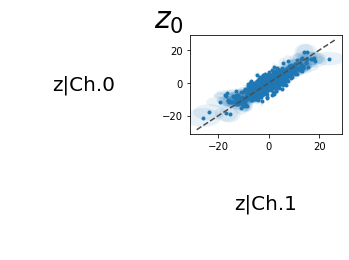

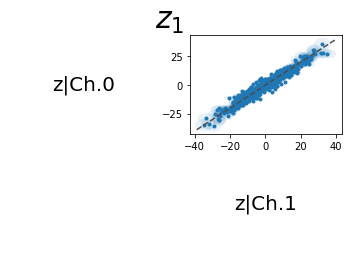

In [371]:
# We plot the remaining latent dimensions

diagnostics.plot_latent_space(model_sparse1, data)

In [372]:
# We repeate the same exercise with the synthetic data with redundant dimensions

init_dict = {
    'n_channels': 2, # X and Y
    'lat_dim': n_components + 3,
    'n_feats': tuple([X_ext.shape[1], Y_ext.shape[1]]),
}


data_sparse = []
data_sparse.append(torch.FloatTensor(X_ext))
data_sparse.append(torch.FloatTensor(Y_ext))

adam_lr = 1e-2
n_epochs = 4000

model_sparse = pytorch_modules.MultiChannelSparseVAE(**init_dict)

model_sparse.init_loss()
model_sparse.optimizer = torch.optim.Adam(model_sparse.parameters(), lr=adam_lr)
model_sparse.optimize(epochs = n_epochs, data = data_sparse)

====> Epoch:    0/4000 (0%)	Loss: 123.0720	LL: -117.8757	KL: 5.1963	LL/KL: -22.6845
====> Epoch:  100/4000 (2%)	Loss: 85.2608	LL: -80.5040	KL: 4.7568	LL/KL: -16.9238
====> Epoch:  200/4000 (5%)	Loss: 80.6176	LL: -74.9821	KL: 5.6354	LL/KL: -13.3055
====> Epoch:  300/4000 (8%)	Loss: 76.9524	LL: -70.5537	KL: 6.3986	LL/KL: -11.0264
====> Epoch:  400/4000 (10%)	Loss: 75.8862	LL: -68.6471	KL: 7.2391	LL/KL: -9.4829
====> Epoch:  500/4000 (12%)	Loss: 75.1691	LL: -66.8673	KL: 8.3018	LL/KL: -8.0546
====> Epoch:  600/4000 (15%)	Loss: 74.4258	LL: -65.5112	KL: 8.9145	LL/KL: -7.3488
====> Epoch:  700/4000 (18%)	Loss: 74.3130	LL: -65.2063	KL: 9.1067	LL/KL: -7.1603
====> Epoch:  800/4000 (20%)	Loss: 74.4731	LL: -65.4117	KL: 9.0615	LL/KL: -7.2187
====> Epoch:  900/4000 (22%)	Loss: 74.6627	LL: -65.5818	KL: 9.0808	LL/KL: -7.2220
====> Epoch: 1000/4000 (25%)	Loss: 74.5580	LL: -65.5282	KL: 9.0297	LL/KL: -7.2569
====> Epoch: 1100/4000 (28%)	Loss: 74.2903	LL: -65.3030	KL: 8.9874	LL/KL: -7.2661
====> Epoch: 1

We see that the model recognises again only two meaningful latent dimensions

In [373]:
print('Probability of redundancy: ', model_sparse.dropout.detach().numpy())
indices = np.where(model_sparse.dropout.detach().numpy().flatten() < 0.9)[0]
print('Non-redundant components: ', indices)

Probability of redundancy:  [[0.9955844  0.06833608 0.9955112  0.9949803  0.02181265 0.9960193 ]]
Non-redundant components:  [1 4]


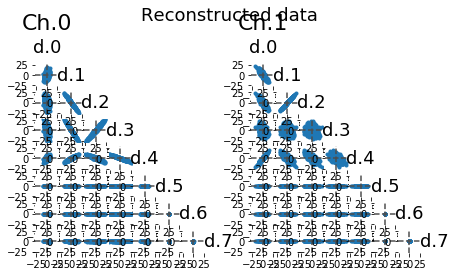

In [374]:
model_sparse.dropout_threshold = 0.2

x_hat = model_sparse.reconstruct(data_sparse)
plot.lsplom(utilities.ltonumpy(x_hat), title = 'Reconstructed data')

Dropout threshold: 0.2
Components kept: [1, 4]


<Figure size 864x576 with 0 Axes>

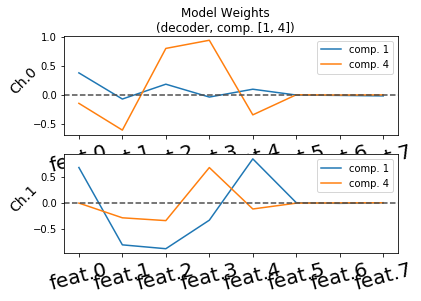

In [375]:
## Plotting the weights of the decoder

plt.figure(figsize=(12, 8))
diagnostics.plot_weights(model_sparse, side = 'decoder')

Dropout threshold: 0.2
Components kept: [1, 4]


<Figure size 864x576 with 0 Axes>

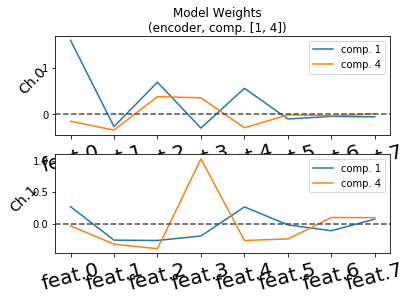

In [376]:
plt.figure(figsize=(12, 8))
diagnostics.plot_weights(model_sparse, side = 'encoder')

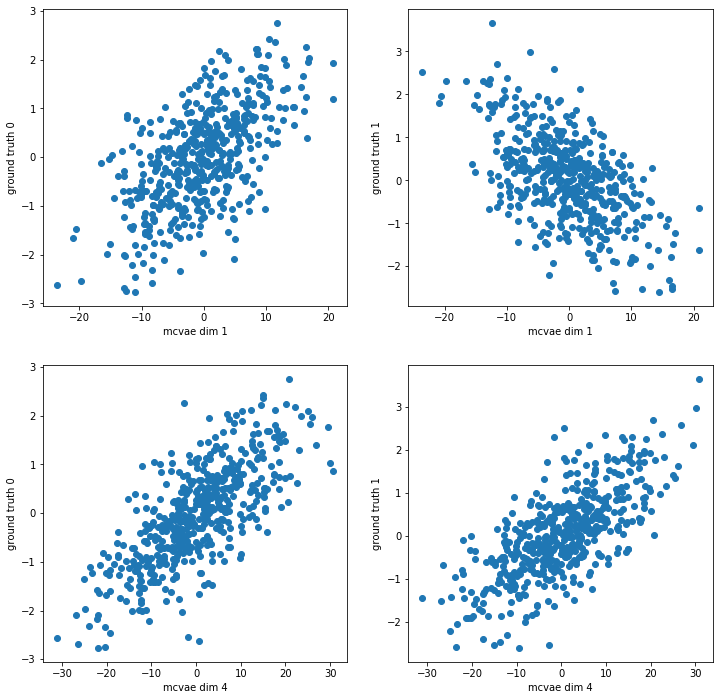

In [377]:
# PLotting estimated encoding vs ground truth

encoding = model_sparse.encode(data_sparse)

encoding_x = encoding[0].loc.detach().numpy()
encoding_y = encoding[1].loc.detach().numpy()

plt.figure(figsize=(12, 12))
for idx,k in enumerate(indices):
  plt.subplot(len(indices),2,2*idx+1)
  plt.scatter(encoding_x[:,k], latents[:,0])
  plt.xlabel(str('mcvae dim ') + str(k))
  plt.ylabel('ground truth 0')
  plt.subplot(len(indices),2,2*idx+2)
  plt.scatter(encoding_x[:,k], latents[:,1])
  plt.xlabel(str('mcvae dim ') + str(k))
  plt.ylabel('ground truth 1')

plt.show()

Dropout threshold: 0.5
Components kept: [0, 1]


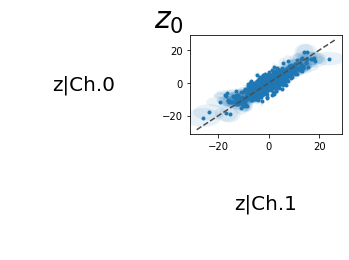

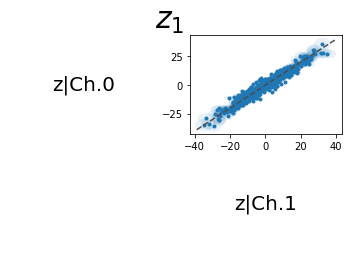

In [378]:
diagnostics.plot_latent_space(model_sparse1, data)

### Increasing the number of channels

In this section we explore the use of the model on data with multiple modalities (or channels)

In [0]:
# generating a new modality z
# This modality has meaningful as well as redundant dimensions

size_z = 3
size_z_redundant = 4

transform_z = np.random.randint(-8,8, size = 2*size_z).reshape([2,size_z])

Z = latents.dot(transform_z) + 2*np.random.normal(size = n*size_z).reshape((n, size_z))
Z = np.hstack([Z,np.random.randn(n*size_z_redundant).reshape([n,size_z_redundant])])

In [380]:
init_dict = {
    'n_channels': 3, # X and Y
    'lat_dim': n_components + 3,
    'n_feats': tuple([X_ext.shape[1], Y_ext.shape[1], Z.shape[1]]),
}


data_multi = []
data_multi.append(torch.FloatTensor(X_ext))
data_multi.append(torch.FloatTensor(Y_ext))
data_multi.append(torch.FloatTensor(Z))

adam_lr = 1e-2
n_epochs = 4000

model_multi = pytorch_modules.MultiChannelSparseVAE(**init_dict)

model_multi.init_loss()
model_multi.optimizer = torch.optim.Adam(model_multi.parameters(), lr=adam_lr)
model_multi.optimize(epochs = n_epochs, data = data_multi)

====> Epoch:    0/4000 (0%)	Loss: 257.8728	LL: -250.1387	KL: 7.7341	LL/KL: -32.3423
====> Epoch:  100/4000 (2%)	Loss: 180.2015	LL: -171.4095	KL: 8.7920	LL/KL: -19.4960
====> Epoch:  200/4000 (5%)	Loss: 167.5350	LL: -156.8316	KL: 10.7034	LL/KL: -14.6524
====> Epoch:  300/4000 (8%)	Loss: 158.5357	LL: -145.8271	KL: 12.7086	LL/KL: -11.4747
====> Epoch:  400/4000 (10%)	Loss: 154.5528	LL: -140.2687	KL: 14.2841	LL/KL: -9.8199
====> Epoch:  500/4000 (12%)	Loss: 153.1609	LL: -138.0843	KL: 15.0767	LL/KL: -9.1588
====> Epoch:  600/4000 (15%)	Loss: 152.9875	LL: -137.6430	KL: 15.3446	LL/KL: -8.9701
====> Epoch:  700/4000 (18%)	Loss: 152.7427	LL: -137.3840	KL: 15.3587	LL/KL: -8.9450
====> Epoch:  800/4000 (20%)	Loss: 153.2880	LL: -137.9460	KL: 15.3420	LL/KL: -8.9914
====> Epoch:  900/4000 (22%)	Loss: 152.8296	LL: -137.5060	KL: 15.3236	LL/KL: -8.9735
====> Epoch: 1000/4000 (25%)	Loss: 152.9793	LL: -137.6919	KL: 15.2874	LL/KL: -9.0069
====> Epoch: 1100/4000 (28%)	Loss: 152.6012	LL: -137.3742	KL: 15.22

Probability of redundancy:  [[0.9952723  0.03325088 0.99519455 0.99502015 0.9955831  0.01666438]]
Non-redundant components:  [1 5]


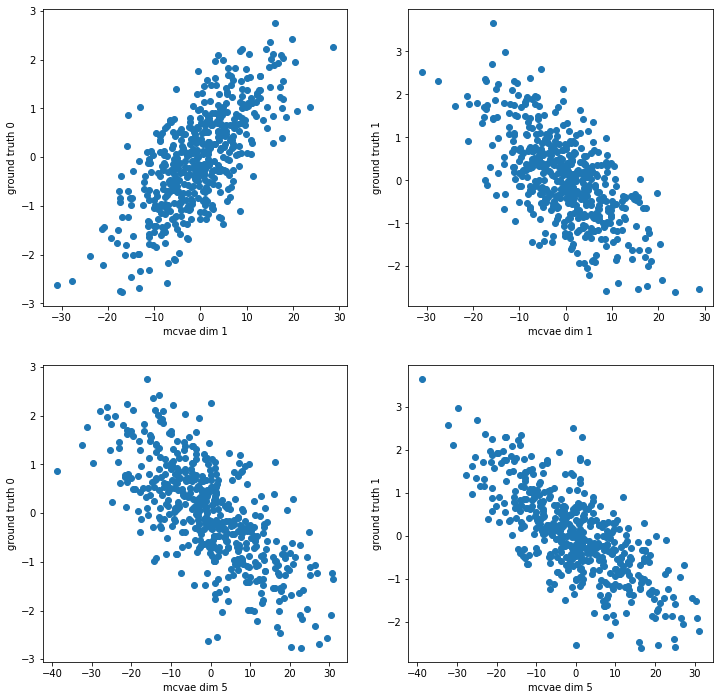

In [381]:
print('Probability of redundancy: ', model_multi.dropout.detach().numpy())
indices = np.where(model_multi.dropout.detach().numpy().flatten() < 0.9)[0]
print('Non-redundant components: ', indices)

model_multi.dropout_threshold = 0.2

encoding = model_multi.encode(data_multi)

encoding_x = encoding[0].loc.detach().numpy()
encoding_y = encoding[1].loc.detach().numpy()
encoding_z = encoding[2].loc.detach().numpy()

plt.figure(figsize=(12, 12))
for idx,k in enumerate(indices):
    plt.subplot(len(indices),2,2*idx+1)
    plt.scatter(encoding_z[:,k], latents[:,0])
    plt.xlabel(str('mcvae dim ') + str(k))
    plt.ylabel('ground truth 0')
    plt.subplot(len(indices),2,2*idx+2)
    plt.scatter(encoding_z[:,k], latents[:,1])
    plt.xlabel(str('mcvae dim ') + str(k))
    plt.ylabel('ground truth 1')

plt.show()

The multi-channel variational autoencoder allows to predict any modality from any other.

In [0]:
# We compute the reconstruction of the data from the encoding
reconstruction = model_multi.decode(model_multi.sample_from(encoding))

# This variable has several dimensions over two indices:
# the first index indicates the modality from which the encoding is done (0:x, 1:y, 3:z, ...) 
# the second index indicates the modality to decode(0:x, 1:y, 3:z, ...)

decoding_x_from_x = reconstruction[0][0].loc.detach().numpy()
decoding_x_from_y = reconstruction[1][0].loc.detach().numpy()
decoding_x_from_z = reconstruction[2][0].loc.detach().numpy()

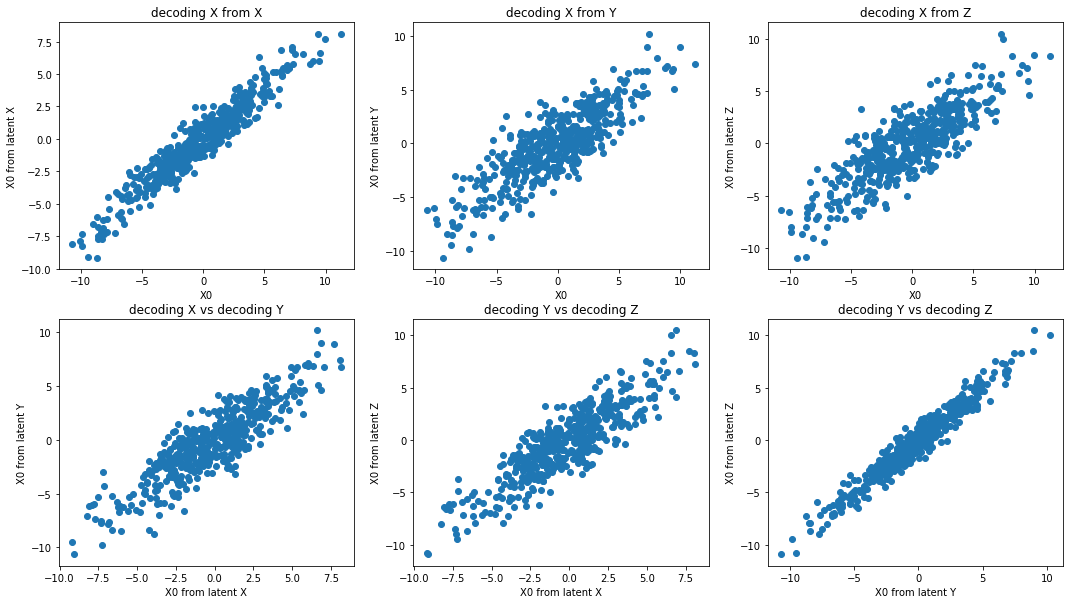

In [383]:
plt.figure(figsize=(18, 10))
plt.subplot(2,3,1)
plt.scatter(X_ext[:,0], decoding_x_from_x[:,0])
plt.title('decoding X from X')
plt.xlabel('X0')
plt.ylabel('X0 from latent X')
plt.subplot(2,3,2)
plt.scatter(X_ext[:,0], decoding_x_from_y[:,0])
plt.title('decoding X from Y')
plt.ylabel('X0 from latent Y')
plt.xlabel('X0')
plt.subplot(2,3,3)
plt.scatter(X_ext[:,0], decoding_x_from_z[:,0])
plt.title('decoding X from Z')
plt.xlabel('X0')
plt.ylabel('X0 from latent Z')
plt.subplot(2,3,4)
plt.scatter(decoding_x_from_x[:,0], decoding_x_from_y[:,0])
plt.title('decoding X vs decoding Y')
plt.xlabel('X0 from latent X')
plt.ylabel('X0 from latent Y')
plt.subplot(2,3,5)
plt.scatter(decoding_x_from_x[:,0], decoding_x_from_z[:,0])
plt.title('decoding Y vs decoding Z')
plt.xlabel('X0 from latent X')
plt.ylabel('X0 from latent Z')
plt.subplot(2,3,6)
plt.scatter(decoding_x_from_y[:,0], decoding_x_from_z[:,0])
plt.title('decoding Y vs decoding Z')
plt.xlabel('X0 from latent Y')
plt.ylabel('X0 from latent Z')
plt.show()

Dropout threshold: 0.2
Components kept: [1, 5]


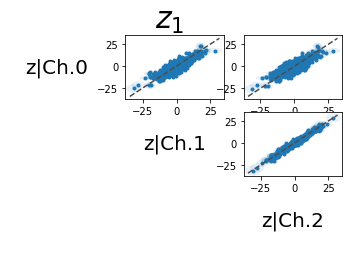

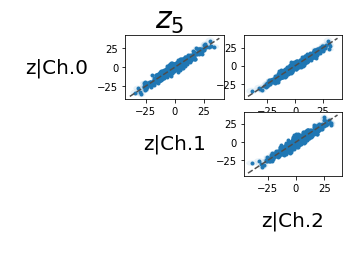

In [384]:
diagnostics.plot_latent_space(model_multi, data_multi)

### Example on ADNI data

In this last application we apply the multichannel autoencoder to the ADNI data, for jointly modeling different modalities across individuals. We wil focus on the joint analysis of:

- brain volumes;
- sociodemographic information (e.g. age, sex, scholarity); 
- cognition; 
- apoe genotype;
- fluid biomarkers (abeta and tay concentrations in the CSF).

In [0]:
import pandas as pd
import torch
from mcvae import pytorch_modules, utilities, preprocessing, plot, diagnostics


We first import and standardize the different data modalities.

In [0]:
volumes = pd.read_csv('https://marcolorenzi.github.io/material/winter_school/volumes.csv')
volumes_value = np.array(volumes.iloc[:,2:]).reshape([len(volumes.RID),5])

for i in range(volumes_value.shape[1]):
    volumes_value[:,i] = (volumes_value[:,i] - np.mean(volumes_value[:,i]))/np.std(volumes_value[:,i])

In [0]:
demog = pd.read_csv('https://marcolorenzi.github.io/material/winter_school/demog.csv')
demog_value = np.array(demog.iloc[:,2:]).reshape([len(demog.RID),3])

for i in range(demog_value.shape[1]):
    demog_value[:,i] = (demog_value[:,i] - np.mean(demog_value[:,i]))/np.std(demog_value[:,i])


In [0]:
cognition = pd.read_csv('https://marcolorenzi.github.io/material/winter_school/cognition.csv')
cognition_value = np.array(cognition.iloc[:,2:]).reshape([len(cognition.RID),7])

for i in range(cognition_value.shape[1]):
    cognition_value[:,i] = (cognition_value[:,i] - np.mean(cognition_value[:,i]))/np.std(cognition_value[:,i])

In [0]:
apoe = pd.read_csv('https://marcolorenzi.github.io/material/winter_school/apoe.csv')
apoe_value = np.array(apoe.iloc[:,2:]).reshape([len(apoe.RID),1])

for i in range(apoe_value.shape[1]):
    apoe_value[:,i] = (apoe_value[:,i] - np.mean(apoe_value[:,i]))/np.std(apoe_value[:,i])

In [0]:
fluid = pd.read_csv('https://marcolorenzi.github.io/material/winter_school/fluid.csv')
fluid_value = np.array(fluid.iloc[:,2:]).reshape(len(apoe.RID),3)

for i in range(fluid_value.shape[1]):
    fluid_value[:,i] = (fluid_value[:,i] - np.mean(fluid_value[:,i]))/np.std(fluid_value[:,i])

We have 5 channels in total as an input for the model

In [0]:
# Defining data characteristics

init_dict = {
    'n_channels': 5, 
    'lat_dim': 5, # We fit 5 latent dimensions
    'n_feats': tuple([volumes_value.shape[1], demog_value.shape[1], cognition_value.shape[1], apoe_value.shape[1], fluid_value.shape[1]]),
}

In [0]:
# Creating a list with multimodal data

data_adni = []
data_adni.append(torch.FloatTensor(volumes_value))
data_adni.append(torch.FloatTensor(np.array(demog_value)))
data_adni.append(torch.FloatTensor(cognition_value))
data_adni.append(torch.FloatTensor(apoe_value))
data_adni.append(torch.FloatTensor(fluid_value))

In [393]:
# Running the model

adam_lr = 1e-2
n_epochs = 6000

model_adni = pytorch_modules.MultiChannelSparseVAE(**init_dict)

model_adni.init_loss()
model_adni.optimizer = torch.optim.Adam(model_adni.parameters(), lr=adam_lr)
model_adni.optimize(epochs = n_epochs, data = data_adni)

====> Epoch:    0/6000 (0%)	Loss: 243.1310	LL: -232.3457	KL: 10.7853	LL/KL: -21.5429
====> Epoch:  100/6000 (2%)	Loss: 193.2603	LL: -188.2761	KL: 4.9843	LL/KL: -37.7740
====> Epoch:  200/6000 (3%)	Loss: 156.3045	LL: -153.4230	KL: 2.8815	LL/KL: -53.2443
====> Epoch:  300/6000 (5%)	Loss: 136.4796	LL: -134.3979	KL: 2.0818	LL/KL: -64.5598
====> Epoch:  400/6000 (7%)	Loss: 131.4205	LL: -129.5546	KL: 1.8659	LL/KL: -69.4343
====> Epoch:  500/6000 (8%)	Loss: 130.9738	LL: -129.0814	KL: 1.8925	LL/KL: -68.2084
====> Epoch:  600/6000 (10%)	Loss: 130.7745	LL: -128.8051	KL: 1.9694	LL/KL: -65.4044
====> Epoch:  700/6000 (12%)	Loss: 130.8810	LL: -128.8564	KL: 2.0246	LL/KL: -63.6467
====> Epoch:  800/6000 (13%)	Loss: 130.8108	LL: -128.7468	KL: 2.0640	LL/KL: -62.3771
====> Epoch:  900/6000 (15%)	Loss: 130.9280	LL: -128.8398	KL: 2.0882	LL/KL: -61.6988
====> Epoch: 1000/6000 (17%)	Loss: 131.1573	LL: -129.0666	KL: 2.0907	LL/KL: -61.7332
====> Epoch: 1100/6000 (18%)	Loss: 131.1046	LL: -129.0100	KL: 2.0946	L

The model identified only a significant dimension, that we are going to store and analyze:

In [394]:
print('Significant dimensions: ', model_adni.dropout.detach().numpy())
significant_dim = np.where(model_adni.dropout.detach().numpy()<0.5)[1]


Significant dimensions:  [[0.9975552  0.9974487  0.997413   0.99745023 0.44762415]]


In [395]:
# Here we store in a list the deconding weights estimated for each modality. 
# We are interested in the decoding weights corresponding to the non-redundant dimension

decoding_weights = []

for i in range(init_dict['n_channels']):
    decoding_weights.append(model_adni.W_out[i].weight.detach().numpy()[:,significant_dim[0]])

decoding_weights[0]

array([-0.22555222,  0.17814463, -0.28510013, -0.24561296, -0.26281703],
      dtype=float32)

The weights give us a nice way to interpret how the different modalities interact together.

<BarContainer object of 3 artists>

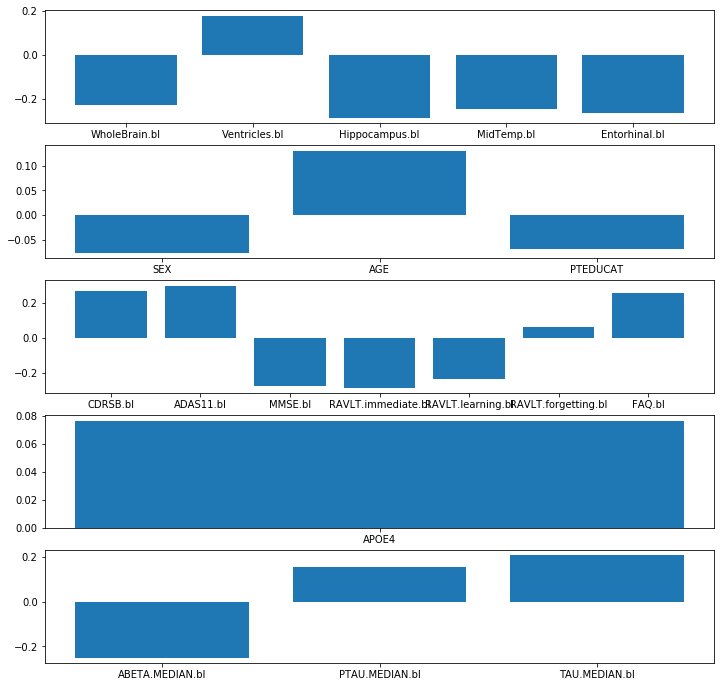

In [396]:
plt.figure(figsize=(12, 12))
plt.subplot(5,1,1)
plt.bar(np.arange(len(decoding_weights[0])), decoding_weights[0], tick_label = volumes.columns[2:])
plt.subplot(5,1,2)
plt.bar(np.arange(len(decoding_weights[1])), decoding_weights[1], tick_label = demog.columns[2:])
plt.subplot(5,1,3)
plt.bar(np.arange(len(decoding_weights[2])), decoding_weights[2], tick_label = cognition.columns[2:])
plt.subplot(5,1,4)
plt.bar(np.arange(len(decoding_weights[3])), decoding_weights[3], tick_label = apoe.columns[2:])
plt.subplot(5,1,5)
plt.bar(np.arange(len(decoding_weights[4])), decoding_weights[4], tick_label = fluid.columns[2:])


Once the model is learnt we can use it for prediction. For example we can predict brain volumes from the cognitive data:

In [0]:
# Storing the predictions
predictions = model_adni.decode(model_adni.sample_from(model_adni.encode(data_adni)))

# Predicting volumes (channel 0) from cognition (channel 2)
decoding_volume_from_cognition = predictions[2][0].loc.detach().numpy()

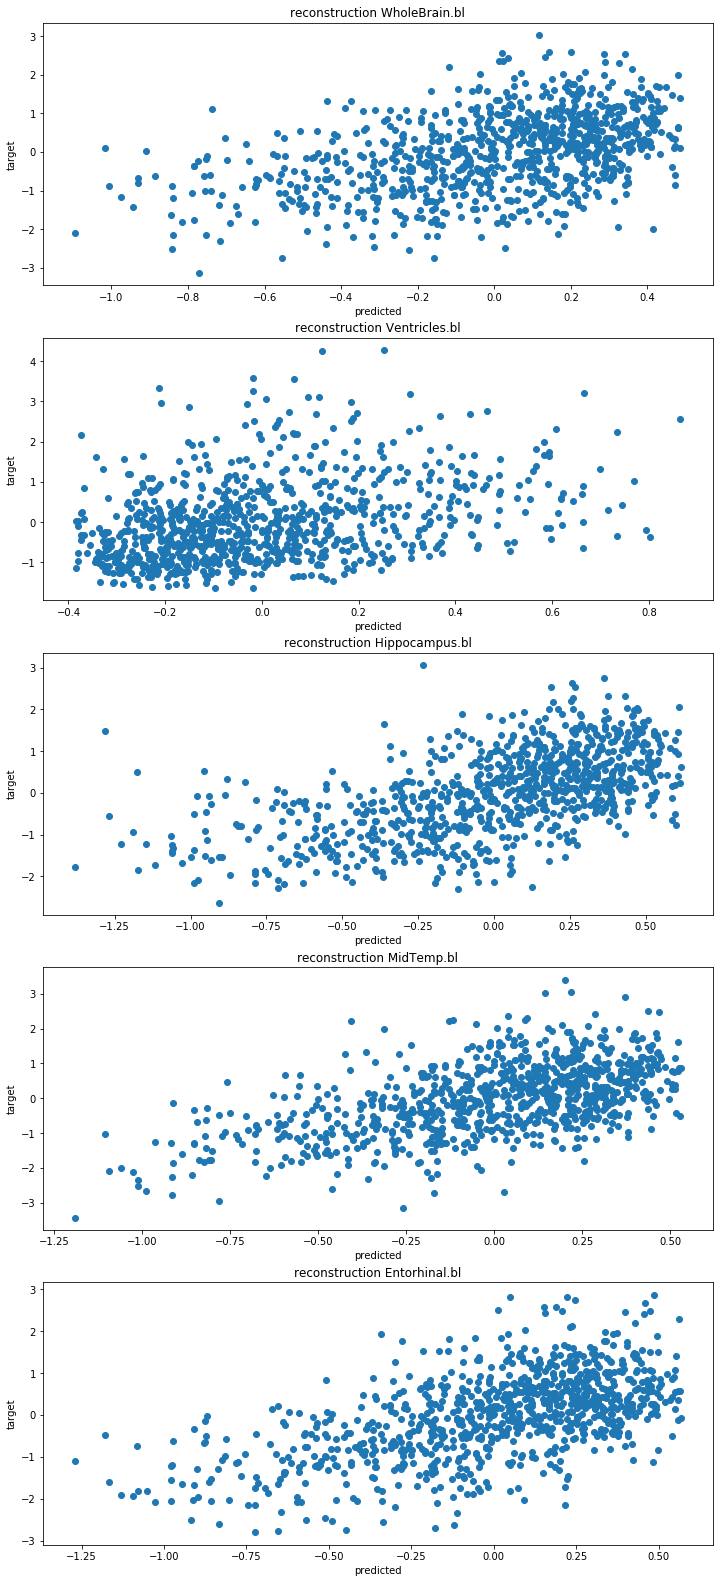

In [398]:
plt.figure(figsize=(12, 28))

# Plotting predictions for each volumetric featurez
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.scatter(decoding_volume_from_cognition[:,i], volumes_value[:,i])
    plt.title('reconstruction ' + volumes.columns[2+i])
    plt.xlabel('predicted')
    plt.ylabel('target')
plt.show()

We are finally going to compare the multichannel model with the standard PLS modeling cognition and brain volumes jointly:

In [399]:
plsca = PLSCanonical(n_components=3, scale = False)
plsca.fit(cognition_value,volumes_value)


[[ 0.39899923  0.10784175  0.46702126]
 [ 0.46449063 -0.17600757  0.30801738]
 [-0.41970768  0.02252307  0.05284719]
 [-0.41480449  0.25193258  0.5752117 ]
 [-0.33759258 -0.35942915  0.527915  ]
 [ 0.09007329  0.86611085  0.09016765]
 [ 0.39338126 -0.11864597  0.25793539]]
[[-0.39539685  0.40966994  0.55358155]
 [ 0.30948675 -0.25355692  0.03687062]
 [-0.50592711 -0.48090226  0.50498596]
 [-0.48167611  0.53524535 -0.4254469 ]
 [-0.50980895 -0.50012484 -0.50613451]]


We obtain predictions from the PLS model and compare them with the predictions of mcvae. We observe a strong correlation between predictions. However, as we increase the number of dimensions of CCA, the difference between prediction increases, as CCA tends to overfit. 

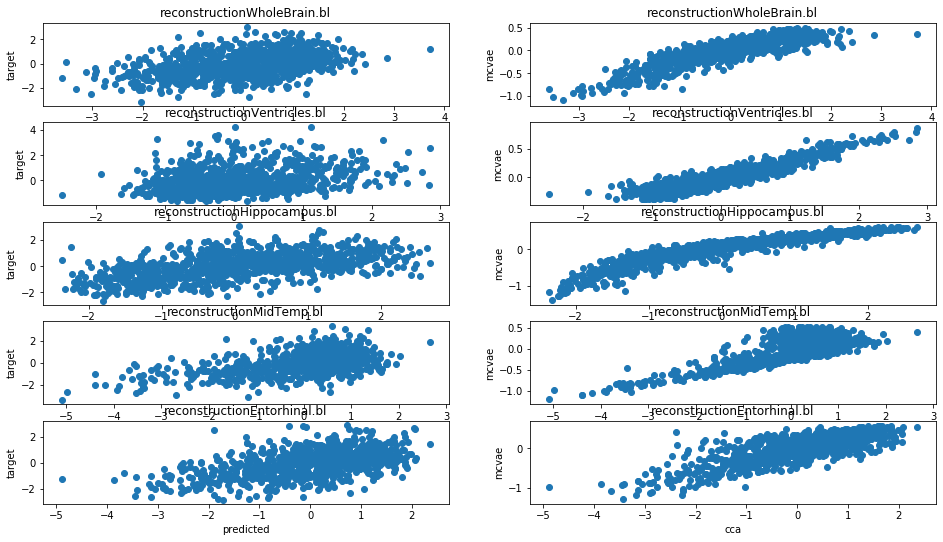

In [400]:
predicted_plsca = plsca.predict(cognition_value)

plt.figure(figsize=(16, 18))

for i in range(5):
    plt.subplot(10,2,2*i+1)
    plt.scatter(predicted_plsca[:,i], volumes_value[:,i])
    plt.title('reconstruction' + volumes.columns[2+i])
    plt.xlabel('predicted')
    plt.ylabel('target')
       
for i in range(5):
    plt.subplot(10,2,2*i+2)
    plt.scatter(predicted_plsca[:,i], decoding_volume_from_cognition[:,i])
    plt.title('reconstruction' + volumes.columns[2+i])
    plt.xlabel('cca')
    plt.ylabel('mcvae')
    
plt.show()

In [401]:
# Comparing average reconstruction errors between models

print('Reconstruction error:')
print('CCA: ' + str(np.sum((predicted_plsca-volumes_value)**2)))
print('mvae: ' + str(np.sum((decoding_volume_from_cognition-volumes_value)**2)))

Reconstruction error:
CCA: 5209.240692014497
mvae: 3543.877985132383


It is interesting to notice that mcvae leads to a lower reconstruction error than CCA. This may be due to the fact that the prediction of mcvae benefits from training from other modalities as well.